In [74]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import random
from sklearn.model_selection import train_test_split

# Lab 12 - Virtual Screening Problem Part II

In this lab, you will revisit the ML problem from Lab 7. Same as that time, this will be a more open lab in which you will have the freedom to experiment with the different ML algorithms we covered until now in class. 

If you haven't yet finished your implementation of Random Forest or Decision Trees, you can take the time to do so during this lab. 

For today, you will be able to also use the sklearn implementation of Decision Trees, Random Forest and Neural Networks. Please refer to the documentation to deploy them correctly. Also, don't hesitate to ask questions when needed!

The task for today is analyse the performance of the different methods when applied to this interesting real-life problem, and obtain the best predictive model. As a side task, you can compare your own implementations of the algorithms with the sklearn ones and see if they behave in the same way and if they don't then try to think what could be causing these differences. 

As you may remember, you had two different set of features to use. You can experiment with both sets of features or even the combination of both. With these many algorithms and parameters to set, the validation set will be very important! Report the performance of each model on a held-out test set with relevant evaluation metrics. 

# Dataset 1

## Importing and Treating Data

In [13]:
# import the data
mol_df = pd.read_csv('cruzi_comp_activity_molecular_features.csv')

# dropping useless column
mol_df.drop(columns=["CID"], inplace = True)

# dropping nan rows
mol_df.dropna(inplace = True)

# Splitting the dataset
x, t = mol_df.values[:, :-1], mol_df.values[:, -1]

t[t <= 1] = 1
t[t > 1] = 0

x_train, x_temp, t_train, t_temp = train_test_split(x, t, test_size = 0.4)
x_valid, x_test, t_valid, t_test = train_test_split(x_temp, t_temp, test_size = 0.5)

## Importing and Defining Functions

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score, f1_score

In [11]:
def get_fpr_tpr(predicted_values, true_labels, threshold):
    prediction_vector = np.zeros(true_labels.size)
    tp, fp, tn, fn = 0, 0, 0, 0  
    
    for i in range(0, true_labels.size):
        if predicted_values[i] > threshold:
            prediction_vector[i] = 1

        if prediction_vector[i] > true_labels[i]: fp += 1
        elif prediction_vector[i] < true_labels[i]: fn += 1
        elif prediction_vector[i] == 1: tp += 1
        else: tn += 1

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn) 
    return fpr, tpr 

def roc_dataframe(predicted_values, true_labels):
    fpr_list = []
    tpr_list = []

    for datapoint in predicted_values:
        fpr, tpr = get_fpr_tpr(predicted_values, true_labels, datapoint)
        fpr_list.append(fpr)
        tpr_list.append(tpr)

    dataframe = pd.DataFrame({"FPR": fpr_list, "TPR": tpr_list})
    return dataframe

## SKLearn Implementations

### Fitting

KNeighborsClassifier(n_neighbors=69)

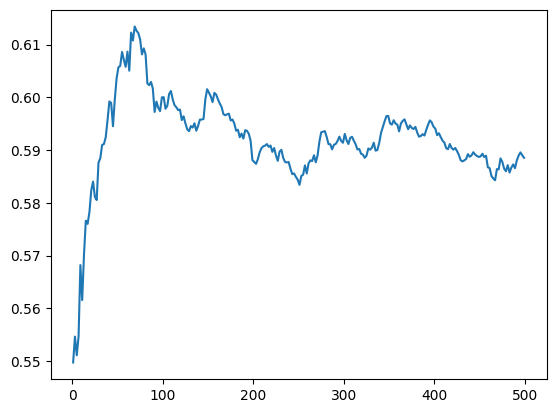

In [15]:
fisher = LinearDiscriminantAnalysis()
logit = LogisticRegression(max_iter = 1000) # We need to increase the max iterations to correctly converge 

# Fitting the models
fisher.fit(x_train, t_train)
logit.fit(x_train, t_train)

# For KNN, let's decide the best K:
k_range = []
scores = []

for k in range(1, 500, 2):
    # For each k, we create a different classifier and take it's score
    knn = KNeighborsClassifier(k) 
    knn.fit(x_train, t_train)
    knn_proba = knn.predict_proba(x_valid)[:, 1]

    scores.append(roc_auc_score(t_valid, knn_proba))
    k_range.append(k)

# We can plot the scores against the k values just for visualization
sns.lineplot(x=k_range, y=scores)

# Finally, let's take the best k and fit it
k = k_range[np.argmax(scores)]
knn = KNeighborsClassifier(k)
knn.fit(x_train, t_train)

### Predicting

<Axes: xlabel='FPR', ylabel='TPR'>

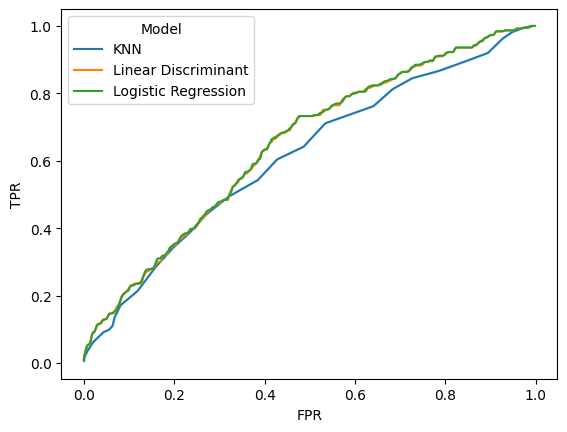

In [18]:
# Now, let's predict the validation set and build the ROC Curve to compare models
knn_proba = knn.predict_proba(x_valid)[:, 1]
fisher_proba = fisher.predict_proba(x_valid)[:, 1]
logit_proba = logit.predict_proba(x_valid)[:, 1]

knn_pred = knn.predict(x_valid)
fisher_pred = fisher.predict(x_valid)
logit_pred = logit.predict(x_valid)

knn_df = roc_dataframe(knn_proba, t_valid)
fisher_df = roc_dataframe(fisher_proba, t_valid)
logit_df = roc_dataframe(logit_proba, t_valid)

# Adding an extra column to plot all the roc curves together
knn_df["Model"] = ["KNN"]*knn_df.shape[0]
fisher_df["Model"] = ["Linear Discriminant"]*fisher_df.shape[0]
logit_df["Model"] = ["Logistic Regression"]*logit_df.shape[0]
# Plotting the ROC
roc_df = pd.concat([knn_df, fisher_df, logit_df], ignore_index = True)
sns.lineplot(data = roc_df, x="FPR", y="TPR", hue = "Model")

### Scores

In [22]:
knn_auroc = roc_auc_score(t_valid, knn_proba)
knn_f1 = f1_score(t_valid, knn_pred)
print(f"KNN Scores:\nAUROC = {knn_auroc}\nF1-Score = {knn_f1}\n")

fisher_auroc = roc_auc_score(t_valid, fisher_proba)
fisher_f1 = f1_score(t_valid, fisher_pred)
print(f"Fisher Discriminant Scores:\nAUROC = {fisher_auroc}\nF1-Score = {fisher_f1}\n")

logit_auroc = roc_auc_score(t_valid, logit_proba)
logit_f1 = f1_score(t_valid, logit_pred)
print(f"Logistic Regression Scores:\nAUROC = {logit_auroc}\nF1-Score = {logit_f1}\n")

KNN Scores:
AUROC = 0.61343329046233
F1-Score = 0.4413793103448275

Fisher Discriminant Scores:
AUROC = 0.6473498950788601
F1-Score = 0.5184049079754601

Logistic Regression Scores:
AUROC = 0.6480200365531712
F1-Score = 0.5206738131699846



### Final Training

The AUROC for the Final Logistic Regression is: 0.6346592994331852


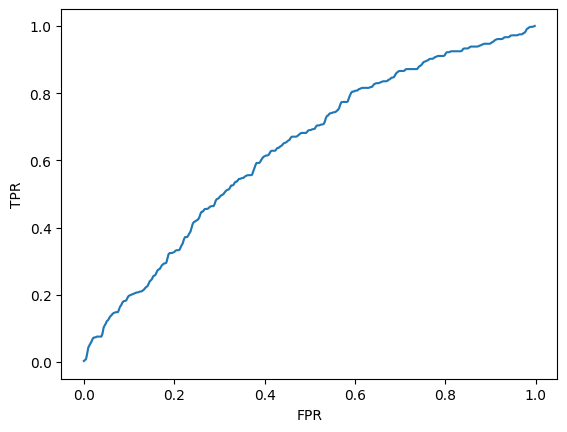

In [169]:
x_final_train = np.vstack((x_train, x_valid))
t_final_train = np.hstack((t_train, t_valid))

logit.fit(x_final_train, t_final_train)
logit_final = fisher.predict_proba(x_test)[:, 1]

# Plotting the ROC
logit_df = roc_dataframe(logit_final, t_test)
sns.lineplot(data = logit_df, x="FPR", y="TPR")

logit_auroc = roc_auc_score(t_test, logit_final)
print(f"The AUROC for the Final Logistic Regression is: {logit_auroc}")

## Personal Implementations

### Definitions

In [177]:
# Fisher 
def fisher_predict(x_train, target_train, x_test):
    x0 = x_train[target_train==0]
    x0_mean = np.mean(x0, axis=0).reshape(-1,1)

    x1 = x_train[target_train==0]
    x1_mean = np.mean(x1, axis=0).reshape(-1,1)

    m = x_train.shape[1]
    sw = np.zeros((m,m))
    for i in range(x0.shape[0]):
        sw += (x0[i].reshape(-1,1) - x0_mean) @ (x0[i].reshape(-1,1) - x0_mean).T

    for i in range(x1.shape[0]):
        sw += np.dot((x1[i].reshape(-1,1) - x1_mean), (x1[i].reshape(-1,1) - x1_mean).transpose())

    w = np.dot(np.linalg.inv(sw), (x1_mean - x0_mean))
    w_proj = np.dot(x_train, w)

    r = RidgeClassifier()
    r.fit(w_proj, target_train)

    test_pred = r.predict(np.dot(x_test, w))
    return test_pred

# Logistic Regression
def sig(a):
    return 1/(1 + np.exp(-a))

def logit_predict(x_train, t, x_test, max_iter = 10, apply_bias = True):
    if apply_bias:
        x_train = np.insert(x_train, 0, 1, axis = 1)
        x_test = np.insert(x_test, 0, 1, axis = 1)

    w = np.zeros(x_train.shape[1])
    
    ce_history = np.zeros(max_iter) # List to store the errors

    for epoch in range(max_iter):
        y = sig(x_train @ w) 
        
        R = np.diagflat(y*(1-y))
        z = x_train @ w - np.linalg.inv(R) @ (y - t)
        
        w = np.linalg.inv(x_train.T @ R @ x_train) @ x_train.T @ R @ z
    
        ce_history[epoch] = -np.sum(t*np.log(y) + (1-t)*np.log(1-y))

    y_pred = (x_test @ w)
    
    return y_pred

# KNN
def euclidean_dist(x1, x2):
    # your code goes here:
    return np.sqrt(np.sum((x1 - x2)**2))    

def knn_predict(x_train, x_test, y_train, k):
    # your code goes here:
    test_predict = np.zeros(x_test.shape[0])

    for datapoint in range(x_test.shape[0]):
        # Calculating the distances of each datapoint to the training points
        distances = np.array([euclidean_dist(x_train[training_point], x_test[datapoint]) for training_point in range(x_train.shape[0])]) 
        
        # Counting how many of the k-nearest neighbours are 0's, how many are 1's, and setting the prediction according to the highest
        k_nearest = np.argsort(distances)[:k]
        test_predict[datapoint] = np.argmax([np.count_nonzero(y_train[k_nearest] == 0), np.count_nonzero(y_train[k_nearest] == 1)])

    return test_predict

# Decision Trees
class DTree():
    """ Decision Tree machine learning model 
    """
    def __init__(self) -> None:
        """Creating a Decision Tree
        """
        self.root = None
        
    def regression_criterion(self, region: np.ndarray):
        """
        Implements the sum of squared error criterion in a region
        
        Parameters
        ----------
        region : ndarray
            Array of shape (N,) containing the target values for N datapoints in the training set.
        
        Returns
        -------
        sse : float
            The sum of squared error (= float("inf") for empty regions)
        """
        if region.size == 0:
            return 9999999999999

        y_hat = np.mean(region)
        sse = np.sum((region-y_hat)**2)
        return sse
    
    def split_region(self, region, feature_index, tau):
        """
        Given a region, splits it in two based on the passed feature, using tau as threshold
        
        Parameters
        ----------
        region : array of size (n_samples, n_features)
            a partition of the dataset (or the full dataset) to be split
        feature_index : int
            the index of the feature (column of the region array) used to make this partition
        tau : float
            The threshold used to make the partitions
            
        Return
        ------
        left_partition : array
            indices of the datapoints in `region` where feature < `tau`
        right_partition : array
            indices of the datapoints in `region` where feature >= `tau` 
        """
        mask = region[:, feature_index] < tau # here I create a mask that says True for a line where the "feature_index" column is lower than "tau"

        left_partition = np.nonzero(mask)[0]
        right_partition = np.nonzero(~mask)[0] # Using the logical inverse of the mask
        return left_partition, right_partition

    def get_split(self, X, y):
        """
        Given a dataset (full or partial), splits it on the feature of that minimizes the sum of squared error
        
        Parameters
        ----------
        X : array (n_samples, n_features)
            features 
        y : array (n_samples, )
            target labels
        
        Returns
        -------
        decision : dictionary
            keys:
            * 'feature_index' -> an integer that indicates the feature (column) of `X` on which the data is split
            * 'tau' -> the threshold used to make the split
            * 'left_region' -> array of indices where the `feature_index`th feature of X is lower than `tau`
            * 'right_region' -> indices not in `left_region`
        """
        best_error = float("inf")
    
        for col in range(X.shape[1]):
            for datapoint in range(X.shape[0]):
                tau = X[datapoint, col]
                l, r = self.split_region(X, col, tau)
                
                l_error = self.regression_criterion(y[l])
                r_error = self.regression_criterion(y[r])
                error = l_error + r_error

                if error < best_error:
                    best_error = error
                    decision = {"feature_index": col, "tau": tau, "left_region": l, "right_region": r}

        return decision

    def recursive_growth(self, min_samples, max_depth, error_criterion, X, y, node = None, current_depth = 0):
        """
        Recursively grows itself by optimizing the error in each node and obeying the passed stopping criterions.
        
        Parameters
        ----------
        min_samples : int
            parameter for stopping criterion if a node has <= min_samples datapoints
        max_depth : int
            parameter for stopping criterion if a node belongs to this depth
        error_criterion : float
            error value to act as stop criterion

        X : array (n_samples, n_features)
            features (full dataset)
        y : array (n_samples, )
            labels (full dataset)
        
        node : dictionary, defaults to self.root
            When passed, the recursive growth will start in this node, and not in the root.
            If the passed node is terminal, it contains only the "value" key, which determines the value to be used as a prediction.
            Else, the dictionary has the structure defined by `get_split`.
            
        current_depth : int, defaults to 0
            current distance from the root
        """
        if not node:
            self.root = self.get_split(X, y)
            node = self.root

        if "left_region" in node:
            l = node["left_region"]
            r = node["right_region"]
            
            # Process left
            if (y[l].size <= min_samples) or (current_depth == max_depth) or (self.regression_criterion(y[l]) <= error_criterion):
                node["left"] = {"value": np.mean(y[l])}
            else:
                node["left"] = self.get_split(X[l], y[l])
                self.recursive_growth(min_samples, max_depth, error_criterion, X, y, node["left"], current_depth+1)   
            
            # Process right
            if (y[r].size <= min_samples) or (current_depth == max_depth) or (self.regression_criterion(y[r]) <= error_criterion):
                node["right"] = {"value": np.mean(y[r])}
            else:
                node["right"] = self.get_split(X[r], y[r])
                self.recursive_growth(min_samples, max_depth, error_criterion, X, y, node["right"], current_depth+1)

    def print_tree(self, node = None, depth = 0):
        """Prints the whole tree

        :param node: Node from where to start printing, defaults to self.root
        :type node: dict, optional
        :param depth: Current depth of the node, defaults to 0 (root depth)
        :type depth: int, optional
        """
        if not node: 
            node = self.root

        if 'value' in node.keys():
            print('.  '*(depth-1), f"[{node['value']}]")
        else:
            print('.  '*depth, f'X_{node["feature_index"]} < {node["tau"]}')
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)

    def __predict_sample(self, sample, node = None):
        """
        Makes a prediction based on the decision tree defined by `node`
        
        Parameters
        ----------
        sample : array of size (n_features,)
            a sample datapoint to be predicted
        node : dict, defaults to self.root
            A node created by one of the methods above
        """
        if not node: 
            node = self.root

        if "value" in node.keys():
            return node["value"]
        
        if sample[node["feature_index"]] < node["tau"]:
            return self.__predict_sample(sample, node["left"])
        
        return self.__predict_sample(sample, node["right"])
        
    def predict(self, X):
        """
        Makes a prediction based on the fitted training data
        
        Parameters
        ----------
        X : array of size (n_samples, n_features)
            n_samples predictions will be made

        Returns
        -------
        np.ndarray (n_samples, )
            Unidimensional array with predicted values or labels for each datapoint in the dataset 'X'
        """
        prediction = []
        for datapoint in X:
            prediction.append(self.__predict_sample(datapoint))
        
        return np.array(prediction)
    
# Random Forest 
class Random_Forest():
    def __init__(self):
        self.x = None
        self.targets = None

        self.bags = None

        self.estimators = []

    def fit(self, x_train, target_train):
        self.x = x_train
        self.targets = target_train

    def bootstrap(self, num_bags=10):
        """ Given a dataset and a number of bags, sample the dataset with replacement.
        This method does not return a copy of the datapoints, but stores in self.bags a list of indices with compatible dimensionality
        
        Parameters
        ----------
        num_bags : int, default 10
            The number of bags to create
        
        Notes
        -----
        * The number of datapoints in each bach will match the number of datapoints in the given dataset.
        """
        rng = np.random.default_rng(42) # you can change the seed, or use 0 to replicate my results
        self.bags = [rng.integers(0, self.x.shape[0], self.x.shape[0]) for i in range(num_bags)] 

    def __aggregate_regression(self, preds):
        """ Aggregate predictions by several estimators
        
        Parameters
        ----------
        preds : list of ndarray
            Predictions from multiple estimators.
            All ndarrays in this list should have the same dimensionality.
            
        Return
        ------
        ndarray
            The mean of the predictions
        """
        return np.mean(np.array(preds), 0)
        
    def __get_features_set(self, feat_num, chosen_num):
        """ Chooses a subset of features between the total number

        :param feat_num: Original number of features
        :type feat_num: int
        :param chosen_num: Number of features to be chosen between the original ones
        :type chosen_num: int

        :return: List of indexes to access a subset of the features
        :rtype: list
        """
        chosen_feats = random.choices(range(feat_num), k = chosen_num)
        return chosen_feats

    def fit_bagging(self, X, y: np.ndarray, num_features, num_estimators, min_samples, max_depht):
        """ Creates a random forest model with 'num_estimators' trees, each trained with a subset of 'num_features' features between the original ones in the dataset 'X'

        :param X: Full dataset to fit in the random forest's trees
        :type X: np.ndarray
        :param y: Full dataset labels
        :type y: np.ndarray

        :param num_features: Number of features to use in each singular tree
        :type num_features: int
        :param num_estimators: Number of trees in the random forest
        :type num_estimators: int
        :param min_samples: Parameter for a tree's stopping criterion if a node has <= min_samples datapoints
        :type min_samples: int
        :param max_depht: Parameter for a tree's stopping criterion if a node belongs to this depth
        :type max_depht: int
        """
        self.estimators.clear()
        n_features = X.shape[1]

        if y.ndim == 2:
            y = y.reshape(-1)
        self.fit(X, y)
        
        self.bootstrap(num_estimators)

        for i in range(num_estimators):
            estimator = DTree()

            # Separating a subset with fewer features and the same amount of datapoints (random with replacement)
            features = self.__get_features_set(n_features, num_features)
            X_subset = X[self.bags[i]][:, features]
            y_subset = y[self.bags[i]]
            
            # Training the tree with the defined subsets of data
            estimator.recursive_growth(min_samples, max_depht, 0, X_subset, y_subset)

            self.estimators.append(estimator)

    def predict(self, X):
        """Makes the prediction for a Random Forest Model

        :param estimators: List with many DTree class estimators
        :type estimators: list[DTree]
        :param X: Dataset to predict the labels
        :type X: np.ndarray
        :return: Returns an array with the average from all the predictions in the random forest
        :rtype: np.ndarray
        """
        predictions = []

        for tree in self.estimators:
            predictions.append(tree.predict(X))
        
        return self.__aggregate_regression(predictions)


### Predicting

In [70]:
my_fisher_pred = fisher_predict(x_train, t_train, x_valid)
my_logit_prob = logit_predict(x_train, t_train, x_valid)
my_knn_pred = knn_predict(x_train, x_valid, t_train, 69) # I'll already apply the same K found for the sklearn model

[Text(50.722222222222214, 0.5, 'Minimum Samples'),
 Text(0.5, 23.52222222222222, 'Max Depth')]

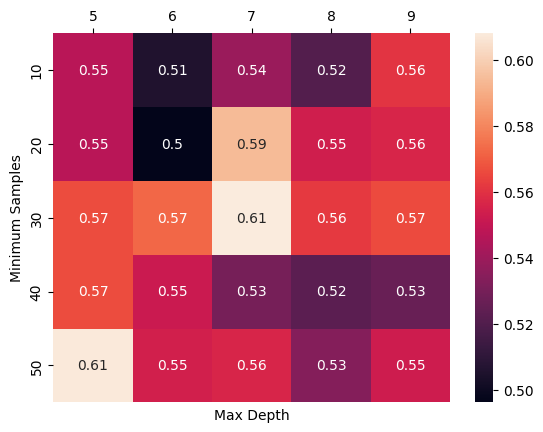

In [121]:
min_samples = range(10, 51, 10)
max_depth = range(5, 10)

data = np.zeros((len(min_samples), len(max_depth)))

for samp in range(len(min_samples)):
    for dep in range(len(max_depth)):
        tree = DTree()
        tree.recursive_growth(min_samples[samp], max_depth[dep], 0, x_train, t_train)
        valid_predict = tree.predict(x_valid)
        data[samp,dep] = roc_auc_score(t_valid, valid_predict)

plot_df0 = pd.DataFrame(data, min_samples, max_depth)

ax = sns.heatmap(plot_df0, annot=True)
ax.xaxis.tick_top()
ax.set(ylabel="Minimum Samples", xlabel="Max Depth")

In [123]:
best_tree_score = np.max(data)

best_min_samples = min_samples[np.unravel_index(np.argmax(data), data.shape)[0]]
best_max_depht = max_depth[np.unravel_index(np.argmax(data), data.shape)[1]]

c:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(50.722222222222214, 0.5, 'Minimum Samples'),
 Text(0.5, 23.52222222222222, 'Max Depth')]

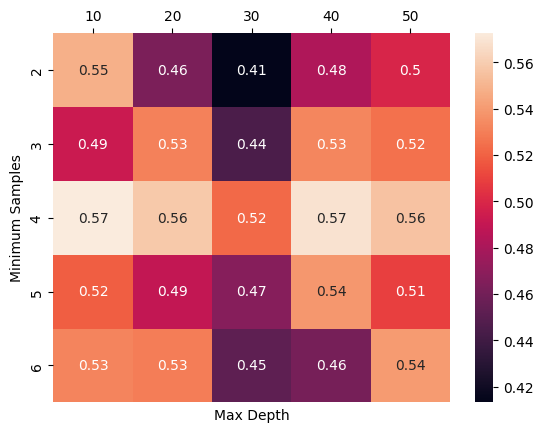

In [162]:
numbers_feat = range(2, 7)
numbers_estim = range(10, 51, 10)
data2 = np.zeros((len(numbers_feat), len(numbers_estim)))

for feat in range(len(numbers_feat)):
    for est in range(len(numbers_estim)):
        forest = Random_Forest()
        forest.fit_bagging(x_train, t_train, numbers_feat[feat], numbers_estim[est], best_min_samples, best_max_depht)
        
        y_pred = forest.predict(x_valid)
        data2[feat, est] = roc_auc_score(t_valid, y_pred)

plot_df1 = pd.DataFrame(data2, numbers_feat, numbers_estim)

ax = sns.heatmap(plot_df1, annot=True)
ax.xaxis.tick_top()
ax.set(ylabel="Minimum Samples", xlabel="Max Depth")


In [163]:
best_forest_score = np.max(data2)

0.5727306572801734

### Scores

In [165]:
knn_f1 = f1_score(t_valid, my_knn_pred)
print(f"KNN Scores:\nF1-Score = {knn_f1}\n")

fisher_f1 = f1_score(t_valid, my_fisher_pred)
print(f"Fisher Discriminant Scores:\nF1-Score = {fisher_f1}\n")

my_logit_pred = np.zeros(my_logit_prob.shape)
my_logit_pred[my_logit_prob >= 0.5] = 1

logit_auroc = roc_auc_score(t_valid, my_logit_prob)
logit_f1 = f1_score(t_valid, my_logit_pred)
print(f"Logistic Regression Scores:\nAUROC = {logit_auroc}\nF1-Score = {logit_f1}\n")

print(f"Decision Tree Score:\nAUROC = {best_tree_score}\n")

print(f"Random Forest Score:\nAUROC = {best_forest_score}")

KNN Scores:
F1-Score = 0.4413793103448275

Fisher Discriminant Scores:
F1-Score = 0.0

Logistic Regression Scores:
AUROC = 0.6479388072835579
F1-Score = 0.341948310139165

Decision Tree Score:
AUROC = 0.6082380017599676

Random Forest Score:
AUROC = 0.5727306572801734


### Final Training

The AUROC for my Final Logistic Regression is: 0.6315465753238456


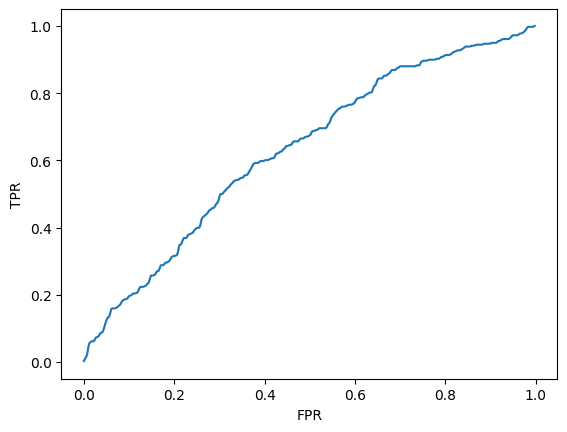

In [168]:
my_logit_final = logit_predict(x_final_train, t_final_train, x_test)

# Plotting the ROC
logit_df = roc_dataframe(my_logit_final, t_test)
sns.lineplot(data = logit_df, x="FPR", y="TPR")

my_logit_auroc = roc_auc_score(t_test, my_logit_final)
print(f"The AUROC for my Final Logistic Regression is: {my_logit_auroc}")

## Dataset 1 - Results

Through my observations, we can see that, first of all, the SKLearn implementations are far better, probably because they have a lot more of data treatment and problem-solving inside their classes, while mine are far more simple.

It's interesting to note that my linear discriminant failed to predict the data, probably because it's far more fragile to multi-featured datasets (I originally implemented it only for two dimensions, like a common bidimensional discriminant).

In the end, in both cases the Logistic Regression excelled the other models in predicting the classes (what is pretty frustrating since I was hoping the Random Forest would win this race. It's probably also due to the fact I firs implemented the Random Forest to make regression predictions, and not for classification).

Finally, in the final training where we merge both the training and validation sets, we can see that my implementation of the Logistic Regression makes up to the SKLearn's, wich at least makes me a little proud :) 

# Dataset 2

## Treating and Splitting

In [170]:
# load the other dataset containing different features
struct_df = pd.read_csv('cruzi_comp_activity_structural_features.csv')

struct_df.drop(columns=["CID"], inplace = True)

x2, t2 = struct_df.values[:, :-1], struct_df.values[:, -1]

t2[t2 <= 1] = 1
t2[t2 > 1] = 0

x2_train, x2_temp, t2_train, t2_temp = train_test_split(x2, t2, test_size = 0.4)
x2_valid, x2_test, t2_valid, t2_test = train_test_split(x2_temp, t2_temp, test_size = 0.5)

## SKLearn

### Fitting

KNeighborsClassifier(n_neighbors=13)

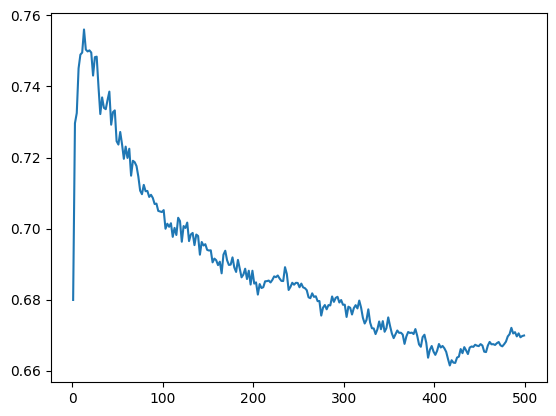

In [171]:
fisher2 = LinearDiscriminantAnalysis()
logit2 = LogisticRegression(max_iter = 1000)

fisher2.fit(x2_train, t2_train)
logit2.fit(x2_train, t2_train)

k_range = []
scores = []

for k in range(1, 500, 2):
    knn2 = KNeighborsClassifier(k) 
    knn2.fit(x2_train, t2_train)
    knn2_proba = knn2.predict_proba(x2_valid)[:, 1]

    scores.append(roc_auc_score(t2_valid, knn2_proba))
    k_range.append(k)

sns.lineplot(x=k_range, y=scores)

k = k_range[np.argmax(scores)]
knn2 = KNeighborsClassifier(k)
knn2.fit(x2_train, t2_train)

### Predicting

<Axes: xlabel='FPR', ylabel='TPR'>

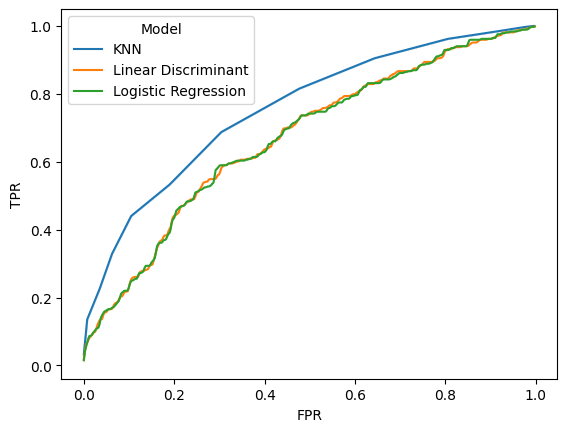

In [173]:
# Now, let's predict the validation set and build the ROC Curve to compare models
knn2_proba = knn2.predict_proba(x2_valid)[:, 1]
fisher2_proba = fisher2.predict_proba(x2_valid)[:, 1]
logit2_proba = logit2.predict_proba(x2_valid)[:, 1]

knn2_df = roc_dataframe(knn2_proba, t2_valid)
fisher2_df = roc_dataframe(fisher2_proba, t2_valid)
logit2_df = roc_dataframe(logit2_proba, t2_valid)

# Adding an extra column to plot all the roc curves together
knn2_df["Model"] = ["KNN"]*knn2_df.shape[0]
fisher2_df["Model"] = ["Linear Discriminant"]*fisher2_df.shape[0]
logit2_df["Model"] = ["Logistic Regression"]*logit2_df.shape[0]

# Plotting the ROC
roc2_df = pd.concat([knn2_df, fisher2_df, logit2_df], ignore_index = True)
sns.lineplot(data = roc2_df, x="FPR", y="TPR", hue = "Model")

### Scores

In [174]:
knn2_auroc = roc_auc_score(t2_valid, knn2_proba)
print(f"The AUROC for the K-Nearest Neighbors is: {knn2_auroc}")

fisher2_auroc = roc_auc_score(t2_valid, fisher2_proba)
print(f"The AUROC for the Linear Discriminant Analysis is: {fisher2_auroc}")

logit2_auroc = roc_auc_score(t2_valid, logit2_proba)
print(f"The AUROC for the Logistic Regression is: {logit2_auroc}")


The AUROC for the K-Nearest Neighbors is: 0.7560345061259893
The AUROC for the Linear Discriminant Analysis is: 0.6696709313672341
The AUROC for the Logistic Regression is: 0.6688441938631682


### Final Training

The AUROC for the Final K-Nearest Neighbours is: 0.7467021859216638


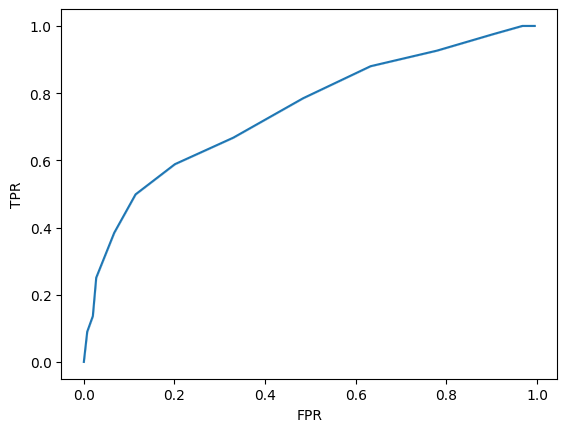

In [175]:
x2_final_train = np.vstack((x2_train, x2_valid))
t2_final_train = np.hstack((t2_train, t2_valid))

knn2.fit(x2_final_train, t2_final_train)
knn2_proba = knn2.predict_proba(x2_test)[:, 1]

# Plotting the ROC
knn2_df = roc_dataframe(knn2_proba, t2_test)
sns.lineplot(data = knn2_df, x="FPR", y="TPR")

knn2_auroc = roc_auc_score(t2_test, knn2_proba)
print(f"The AUROC for the Final K-Nearest Neighbours is: {knn2_auroc}")

## My Implementations

### Fitting

In [178]:
my_fisher_pred2 = fisher_predict(x2_train, t2_train, x2_valid)
my_logit_prob2 = logit_predict(x2_train, t2_train, x2_valid)
my_knn_pred2 = knn_predict(x2_train, x2_valid, t2_train, 13)

[Text(50.722222222222214, 0.5, 'Minimum Samples'),
 Text(0.5, 23.52222222222222, 'Max Depth')]

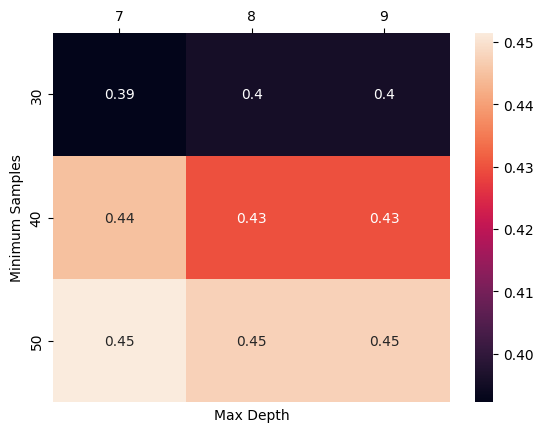

In [181]:
min_samples = range(30, 51, 10)
max_depth = range(7, 10)

data = np.zeros((len(min_samples), len(max_depth)))

for samp in range(len(min_samples)):
    for dep in range(len(max_depth)):
        tree = DTree()
        tree.recursive_growth(min_samples[samp], max_depth[dep], 0, x2_train, t2_train)
        valid_predict = tree.predict(x2_valid)
        data[samp,dep] = roc_auc_score(t2_valid, valid_predict)

plot_df0 = pd.DataFrame(data, min_samples, max_depth)

ax = sns.heatmap(plot_df0, annot=True)
ax.xaxis.tick_top()
ax.set(ylabel="Minimum Samples", xlabel="Max Depth")

In [182]:
best_tree_score = np.max(data)

best_min_samples = min_samples[np.unravel_index(np.argmax(data), data.shape)[0]]
best_max_depht = max_depth[np.unravel_index(np.argmax(data), data.shape)[1]]

[Text(50.722222222222214, 0.5, 'Minimum Samples'),
 Text(0.5, 23.52222222222222, 'Max Depth')]

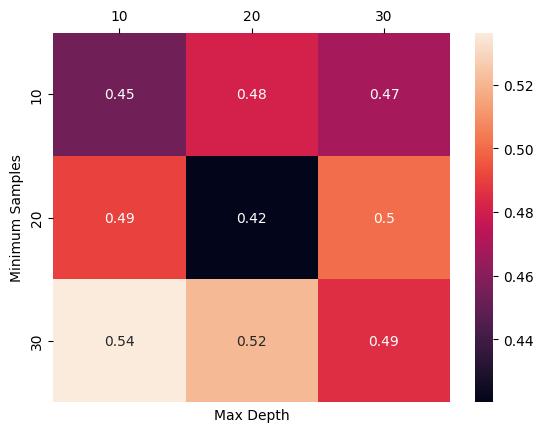

In [186]:
numbers_feat = range(10, 31, 10)
numbers_estim = range(10, 31, 10)
data2 = np.zeros((len(numbers_feat), len(numbers_estim)))

for feat in range(len(numbers_feat)):
    for est in range(len(numbers_estim)):
        forest = Random_Forest()
        forest.fit_bagging(x2_train, t2_train, numbers_feat[feat], numbers_estim[est], best_min_samples, best_max_depht)
        
        y_pred = forest.predict(x2_valid)
        data2[feat, est] = roc_auc_score(t2_valid, y_pred)

plot_df1 = pd.DataFrame(data2, numbers_feat, numbers_estim)

ax = sns.heatmap(plot_df1, annot=True)
ax.xaxis.tick_top()
ax.set(ylabel="Minimum Samples", xlabel="Max Depth")

In [187]:
best_forest_score2 = np.max(data2)

### Scores

In [189]:
knn_f1 = f1_score(t2_valid, my_knn_pred2)
print(f"KNN Scores:\nF1-Score = {knn_f1}\n")

fisher_f1 = f1_score(t2_valid, my_fisher_pred2)
print(f"Fisher Discriminant Scores:\nF1-Score = {fisher_f1}\n")

my_logit_pred2 = np.zeros(my_logit_prob2.shape)
my_logit_pred2[my_logit_prob2 >= 0.5] = 1

logit_auroc = roc_auc_score(t2_valid, my_logit_prob2)
logit_f1 = f1_score(t2_valid, my_logit_pred2)
print(f"Logistic Regression Scores:\nAUROC = {logit_auroc}\nF1-Score = {logit_f1}\n")

print(f"Decision Tree Score:\nAUROC = {best_tree_score}\n")

print(f"Random Forest Score:\nAUROC = {best_forest_score2}")

KNN Scores:
F1-Score = 0.6648793565683645

Fisher Discriminant Scores:
F1-Score = 0.0

Logistic Regression Scores:
AUROC = 0.6681394340236366
F1-Score = 0.4404332129963899

Decision Tree Score:
AUROC = 0.4514461129784234

Random Forest Score:
AUROC = 0.5363628971050635


### Final Training

The AUROC for my Final Logistic Regression is: 0.713815322411613


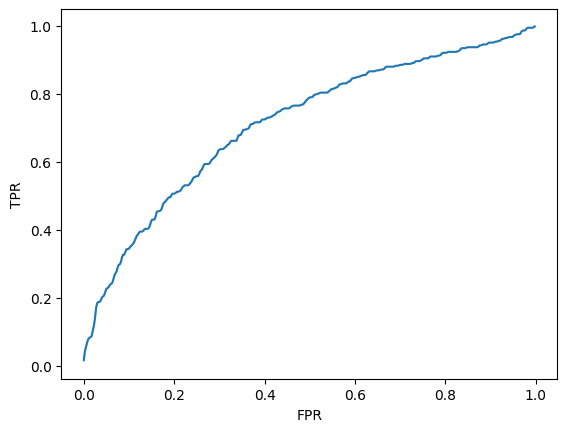

In [190]:
my_logit_final2 = logit_predict(x2_final_train, t2_final_train, x2_test)

# Plotting the ROC
logit_df = roc_dataframe(my_logit_final2, t2_test)
sns.lineplot(data = logit_df, x="FPR", y="TPR")

my_logit_auroc = roc_auc_score(t2_test, my_logit_final2)
print(f"The AUROC for my Final Logistic Regression is: {my_logit_auroc}")

# Dataset 2 - Results

Finally, we can conclude once more that the SKLearn Implementations are better (and more stable) than mine.

What's interesting here is that, while SKLearn's best model was KNN, mine was still Logistic Regression, wich shows that, probably, the Logistic Regression is the most stable implementation I made.

Unfortunately, in the final training my Logistic Regression lost for ScikitLearn's KNN Model, but it still puts up a good fight!